# Question 2: Pitch/Note Detection

In [1]:
import numpy as np
import pandas as pd
import librosa
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Converting MIDI files to WAV
Converting MIDI files to WAV has been done with Convert_MIDI_to_WAV.py.

In [ ]:
!unzip /content/drive/MyDrive/Output.zip

### Plotting
Y and X axes are **Amplitude** and **Time** respectively.

In [172]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

# read audio samples
file1 = read("converted/1_0.wav")
audio1 = file1[1][:,0]

file2 = read("converted/1_12.wav")
audio2 = file2[1][:,0]

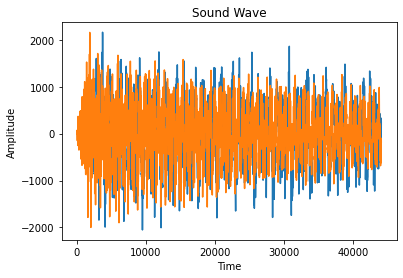

In [173]:
plt.plot(audio1)
plt.plot(audio2)

# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sound Wave")

plt.show()

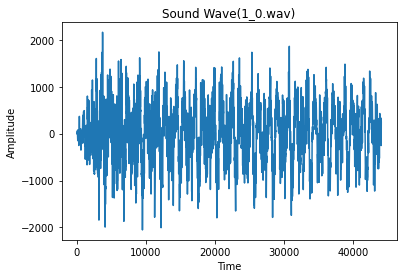

In [174]:
plt.plot(audio1)

# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sound Wave(1_0.wav)")

plt.show()

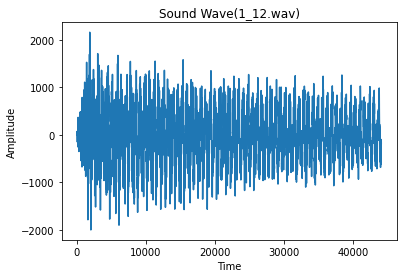

In [175]:
plt.plot(audio2)

# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sound Wave(1_12.wav)")

plt.show()

# Part 2: Train/Validation/Test Split

There are 108 notes for each instrument. We have to split the dataset such that every instrument is represented in training set. For every istrument we select 80%, 20% and 10% of notes randomly for training Train,Validation and Test set respectively. This way it is guaranteed that the dataset is balanced for training.

Note that if we do it randomly on all files, training set could be **Imbalanced**.

* Training Size: 9952 (70%)
* Validation Size: 2489 (20%)
* Test Size: 1383 (10%)

In [176]:
dataset_path = "converted/"
instruments = 128
notes = 108

In [177]:
video_duration = 0.25 # 250ms
librosa_audio_data,librosa_sample_rate=librosa.load("converted/1_0.wav",duration=video_duration)
input_250ms_shape = librosa_audio_data.shape[0]
librosa_audio_data = np.array(librosa_audio_data).reshape(input_250ms_shape,1)
input_250ms_shape

5513

In [178]:
data = {'instrument':[],
        'note':[],
        'path':[]}

for instrument_no in range(0,instruments):
    for notes_no in range(0,notes):
        data['instrument'].append(instrument_no)
        data['note'].append(notes_no)
        path = "converted/"+str(instrument_no)+"_"+str(notes_no)+".wav"
        data['path'].append(path)


df = pd.DataFrame(data)

In [179]:
from sklearn.model_selection import train_test_split

X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.note.values,
    test_size=0.10,
    random_state=42,
    stratify=df.instrument.values,
)

In [180]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].note.values,
    test_size=0.20,
    random_state=42,
    stratify=df.loc[X_train_].instrument.values,  
)

In [181]:
# data_type is not necessary. 
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

### One-hot Encoding

In [182]:
df = pd.concat([pd.get_dummies(data=df, columns=['note']),df['note']],axis = 1)
df

,instrument,path,data_type,note_0,note_1,note_2,note_3,note_4,note_5,note_6,note_7,note_8,note_9,note_10,note_11,note_12,note_13,note_14,note_15,note_16,note_17,note_18,note_19,note_20,note_21,note_22,note_23,note_24,note_25,note_26,note_27,note_28,note_29,note_30,note_31,note_32,note_33,note_34,note_35,note_36,...,note_69,note_70,note_71,note_72,note_73,note_74,note_75,note_76,note_77,note_78,note_79,note_80,note_81,note_82,note_83,note_84,note_85,note_86,note_87,note_88,note_89,note_90,note_91,note_92,note_93,note_94,note_95,note_96,note_97,note_98,note_99,note_100,note_101,note_102,note_103,note_104,note_105,note_106,note_107,note
0,0,converted/0_0.wav,train,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,converted/0_1.wav,train,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,converted/0_2.wav,train,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,converted/0_3.wav,train,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,converted/0_4.wav,train,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13819,127,converted/127_103.wav,val,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,103
13820,127,converted/127_104.wav,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,104
13821,127,converted/127_105.wav,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,105
13822,127,converted/127_106.wav,test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,106


In [183]:
X_train_path = df[df['data_type'] == 'train']['path']
y_train = df[df['data_type'] == 'train'].drop(['instrument','path','data_type','note'],axis = 1)

X_val_path = df[df['data_type'] == 'val']['path']
y_val = df[df['data_type'] == 'val'].drop(['instrument','path','data_type','note'],axis = 1)

X_test_path = df[df['data_type'] == 'test']['path']
y_test = df[df['data_type'] == 'test'].drop(['instrument','path','data_type'],axis = 1)

y_train

,note_0,note_1,note_2,note_3,note_4,note_5,note_6,note_7,note_8,note_9,note_10,note_11,note_12,note_13,note_14,note_15,note_16,note_17,note_18,note_19,note_20,note_21,note_22,note_23,note_24,note_25,note_26,note_27,note_28,note_29,note_30,note_31,note_32,note_33,note_34,note_35,note_36,note_37,note_38,note_39,...,note_68,note_69,note_70,note_71,note_72,note_73,note_74,note_75,note_76,note_77,note_78,note_79,note_80,note_81,note_82,note_83,note_84,note_85,note_86,note_87,note_88,note_89,note_90,note_91,note_92,note_93,note_94,note_95,note_96,note_97,note_98,note_99,note_100,note_101,note_102,note_103,note_104,note_105,note_106,note_107
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
13817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
13818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [184]:
X_train = []
X_val = []
X_test = []

time_frame  = 0.25
for train_path in X_train_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=time_frame)
    X_train.append(librosa_audio_data.tolist())

for val_path in X_val_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=time_frame)
    X_val.append(librosa_audio_data.tolist())

for test_path in X_test_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=time_frame)
    X_test.append(librosa_audio_data.tolist())

X_train= np.array(X_train)
X_val= np.array(X_val)
X_test= np.array(X_test)

In [185]:
print('Train set size: ',len(X_train))
print('Validation set size: ',len(X_val))
print('Test set size: ',len(X_test))

Train set size:  9952
Validation set size:  2489
Test set size:  1383


# Part 3: Implementing Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN,GRU,Dropout

## Part A

### RNN

In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(32,input_shape=(input_250ms_shape, 1)))

# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_9 (Dense)             (None, 108)               3564      
                                                                 
Total params: 4,652
Trainable params: 4,652
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,
                    batch_size = 128,validation_data=(X_val,y_val.values),epochs=10)

Epoch 1/10
78/78 [==============================] - 420s 5s/step - loss: 4.6827 - val_loss: 4.6930
Epoch 2/10
78/78 [==============================] - 419s 5s/step - loss: 4.6861 - val_loss: 4.6850
Epoch 3/10
78/78 [==============================] - 420s 5s/step - loss: 4.6862 - val_loss: 4.6855
Epoch 4/10
78/78 [==============================] - 419s 5s/step - loss: 4.6820 - val_loss: 4.6868
Epoch 5/10
78/78 [==============================] - 418s 5s/step - loss: 4.6828 - val_loss: 4.6943
Epoch 6/10
78/78 [==============================] - 419s 5s/step - loss: 4.6886 - val_loss: 4.7020
Epoch 7/10
78/78 [==============================] - 420s 5s/step - loss: 4.6928 - val_loss: 4.6919
Epoch 8/10
78/78 [==============================] - 421s 5s/step - loss: 4.6886 - val_loss: 4.6936
Epoch 9/10
78/78 [==============================] - 418s 5s/step - loss: 4.6879 - val_loss: 4.6961
Epoch 10/10
78/78 [==============================] - 417s 5s/step - loss: 4.6869 - val_loss: 4.6953
CPU times

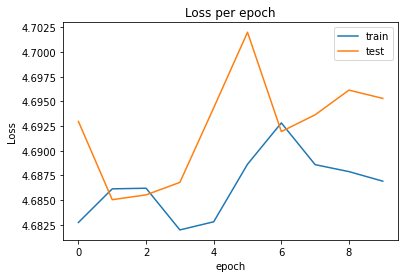

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

### LSTM

In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(128,input_shape=(input_250ms_shape, 1)))

# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_12 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=20)

Epoch 1/20
311/311 [==============================] - 86s 266ms/step - loss: 4.6838 - val_loss: 4.6840
Epoch 2/20
311/311 [==============================] - 82s 264ms/step - loss: 4.6819 - val_loss: 4.6848
Epoch 3/20
311/311 [==============================] - 79s 254ms/step - loss: 4.6838 - val_loss: 4.6857
Epoch 4/20
311/311 [==============================] - 78s 250ms/step - loss: 4.7161 - val_loss: 4.7449
Epoch 5/20
311/311 [==============================] - 79s 255ms/step - loss: 4.7275 - val_loss: 4.7198
Epoch 6/20
311/311 [==============================] - 83s 266ms/step - loss: 4.7140 - val_loss: 4.7104
Epoch 7/20
311/311 [==============================] - 79s 255ms/step - loss: 4.7051 - val_loss: 4.7153
Epoch 8/20
311/311 [==============================] - 79s 254ms/step - loss: 4.7061 - val_loss: 4.7010
Epoch 9/20
311/311 [==============================] - 79s 255ms/step - loss: 4.7037 - val_loss: 4.7018
Epoch 10/20
311/311 [==============================] - 83s 266ms/step - l

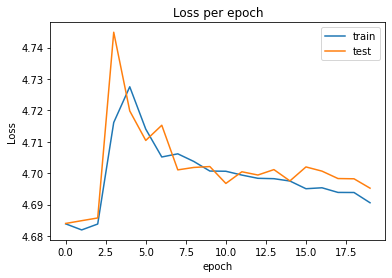

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.01      0.75      0.02        12
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        14
          13       0.02      0.42      0.04        12
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        16
          17       0.00    

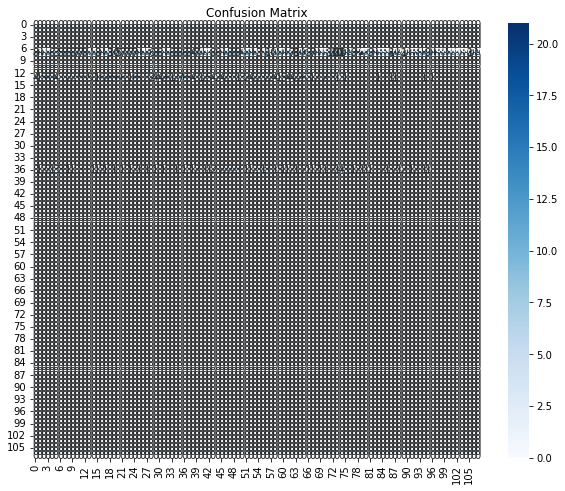

In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

print(classification_report(y_test['note'].values.tolist(), prediction))


### GRU


In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(GRU(128,input_shape=(input_250ms_shape, 1)))

# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_13 (Dense)            (None, 108)               13932     
                                                                 
Total params: 64,236
Trainable params: 64,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=20)


Epoch 1/10
311/311 [==============================] - 73s 229ms/step - loss: 4.6833 - val_loss: 4.6832
Epoch 2/10
311/311 [==============================] - 75s 240ms/step - loss: 4.6821 - val_loss: 4.6845
Epoch 3/10
311/311 [==============================] - 71s 227ms/step - loss: 4.6737 - val_loss: 4.6643
Epoch 4/10
311/311 [==============================] - 70s 227ms/step - loss: 4.6622 - val_loss: 4.6564
Epoch 5/10
311/311 [==============================] - 71s 227ms/step - loss: 4.5812 - val_loss: 4.5444
Epoch 6/10
311/311 [==============================] - 71s 227ms/step - loss: 4.5121 - val_loss: 4.5082
Epoch 7/10
311/311 [==============================] - 71s 228ms/step - loss: 4.4841 - val_loss: 4.4865
Epoch 8/10
311/311 [==============================] - 71s 227ms/step - loss: 4.4657 - val_loss: 4.4699
Epoch 9/10
311/311 [==============================] - 71s 227ms/step - loss: 4.4515 - val_loss: 4.4586
Epoch 10/10
311/311 [==============================] - 71s 227ms/step - l

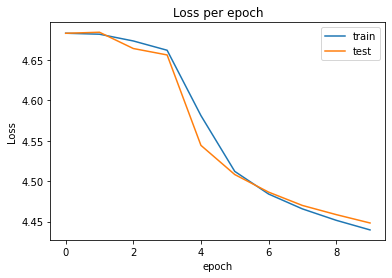

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.04      0.17      0.06        12
           8       0.07      0.25      0.11         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        14
          13       0.02      0.08      0.03        12
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        16
          17       0.00    

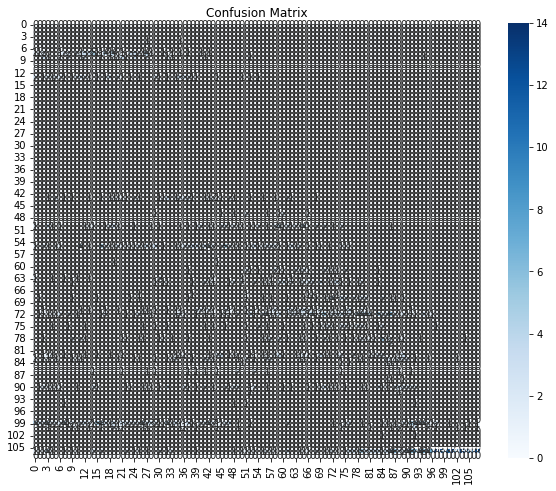

In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

print(classification_report(y_test['note'].values.tolist(), prediction))

## Part B

### Adding Dropout to RNN

In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(32,input_shape=(input_250ms_shape, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 108)               3564      
                                                                 
Total params: 4,652
Trainable params: 4,652
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=10)


Epoch 1/10
311/311 [==============================] - 1156s 4s/step - loss: 4.6880 - val_loss: 4.6867
Epoch 2/10
311/311 [==============================] - 1148s 4s/step - loss: 4.7106 - val_loss: 4.6961
Epoch 3/10
311/311 [==============================] - 1147s 4s/step - loss: 4.7138 - val_loss: 4.6917
Epoch 4/10
311/311 [==============================] - 1132s 4s/step - loss: 4.7540 - val_loss: 4.6963
Epoch 5/10
311/311 [==============================] - 1121s 4s/step - loss: 4.7568 - val_loss: 4.7012
Epoch 6/10
311/311 [==============================] - 1115s 4s/step - loss: 4.7463 - val_loss: 4.7006
Epoch 7/10
311/311 [==============================] - 1107s 4s/step - loss: 4.7377 - val_loss: 4.6962
Epoch 8/10
311/311 [==============================] - 1108s 4s/step - loss: 4.7298 - val_loss: 4.7015
Epoch 9/10
311/311 [==============================] - 1107s 4s/step - loss: 4.7318 - val_loss: 4.6943
Epoch 10/10
311/311 [==============================] - 1107s 4s/step - loss: 4.723

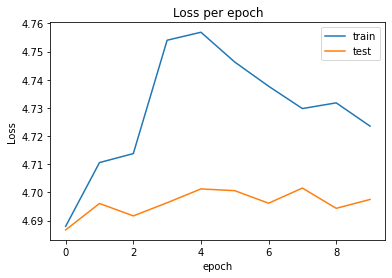

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        16
          17       0.00    

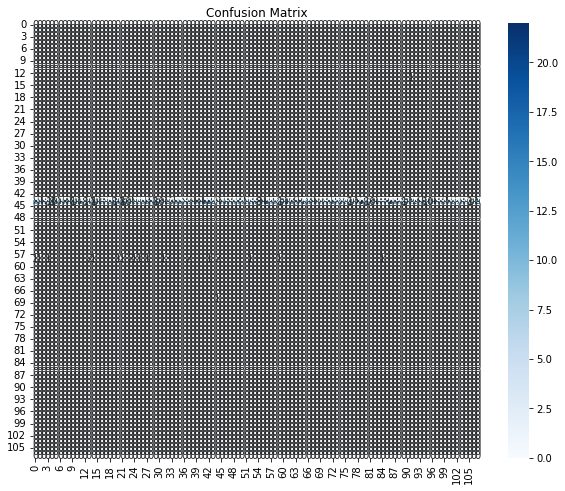

In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

print(classification_report(y_test['note'].values.tolist(), prediction))

### Adding Dropout to LSTM

In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(128,input_shape=(input_250ms_shape, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=10)


Epoch 1/10
311/311 [==============================] - 79s 249ms/step - loss: 4.6832 - val_loss: 4.6841
Epoch 2/10
311/311 [==============================] - 77s 248ms/step - loss: 4.6817 - val_loss: 4.6844
Epoch 3/10
311/311 [==============================] - 77s 248ms/step - loss: 4.6804 - val_loss: 4.6887
Epoch 4/10
311/311 [==============================] - 77s 248ms/step - loss: 4.6816 - val_loss: 4.6872
Epoch 5/10
311/311 [==============================] - 77s 248ms/step - loss: 4.6772 - val_loss: 4.6073
Epoch 6/10
311/311 [==============================] - 78s 251ms/step - loss: 4.6080 - val_loss: 4.6873
Epoch 7/10
311/311 [==============================] - 78s 251ms/step - loss: 4.6444 - val_loss: 4.5948
Epoch 8/10
311/311 [==============================] - 78s 252ms/step - loss: 4.6011 - val_loss: 4.6968
Epoch 9/10
311/311 [==============================] - 78s 251ms/step - loss: 4.6060 - val_loss: 4.4704
Epoch 10/10
311/311 [==============================] - 79s 254ms/step - l

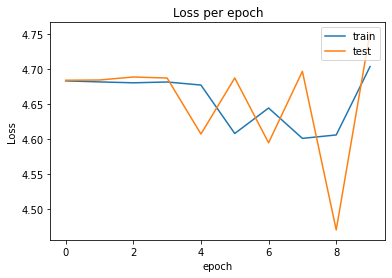

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        16
          17       0.00    

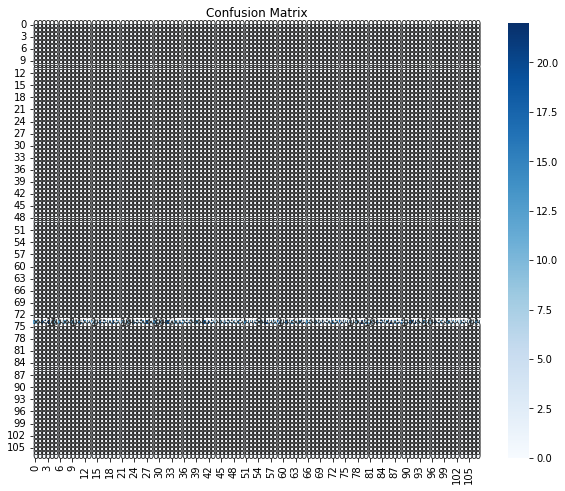

In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

print(classification_report(y_test['note'].values.tolist(), prediction))

### Adding Dropout to GRU


In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(GRU(128,input_shape=(input_250ms_shape, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=10)

Epoch 1/10
311/311 [==============================] - 80s 250ms/step - loss: 4.6833 - val_loss: 4.6838
Epoch 2/10
311/311 [==============================] - 81s 260ms/step - loss: 4.6830 - val_loss: 4.6800
Epoch 3/10
311/311 [==============================] - 77s 247ms/step - loss: 4.6817 - val_loss: 4.6866
Epoch 4/10
311/311 [==============================] - 81s 260ms/step - loss: 4.6791 - val_loss: 4.6740
Epoch 5/10
311/311 [==============================] - 78s 252ms/step - loss: 4.7292 - val_loss: 4.7196
Epoch 6/10
311/311 [==============================] - 83s 266ms/step - loss: 4.7431 - val_loss: 4.6950
Epoch 7/10
311/311 [==============================] - 79s 254ms/step - loss: 4.7252 - val_loss: 4.6971
Epoch 8/10
311/311 [==============================] - 79s 255ms/step - loss: 4.7134 - val_loss: 4.6959
Epoch 9/10
311/311 [==============================] - 79s 255ms/step - loss: 4.7344 - val_loss: 4.7040
Epoch 10/10
311/311 [==============================] - 79s 254ms/step - l

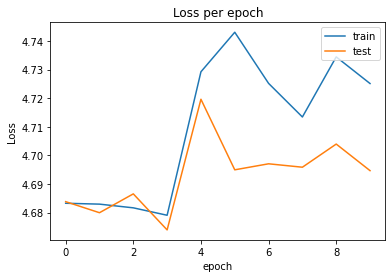

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        16
          17       0.00    

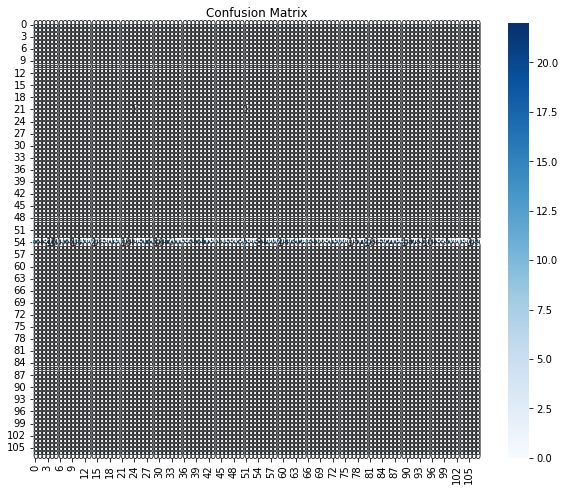

In [ ]:

prediction = model.predict(X_test)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

print(classification_report(y_test['note'].values.tolist(), prediction))


# Part C: Trying different time frame

## Time Frame = 35ms

In [186]:
X_train = []
X_val = []
X_test = []

time_frame  = 0.035
for train_path in X_train_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=time_frame)
    X_train.append(librosa_audio_data.tolist())

for val_path in X_val_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=time_frame)
    X_val.append(librosa_audio_data.tolist())

for test_path in X_test_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=time_frame)
    X_test.append(librosa_audio_data.tolist())

X_train= np.array(X_train)
X_val= np.array(X_val)
X_test= np.array(X_test)

In [187]:
input_35ms = X_train.shape[1]

In [188]:
# define model
model = Sequential()

model.add(GRU(128,input_shape=(input_35ms, 1)))

# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 108)               13932     
                                                                 
Total params: 64,236
Trainable params: 64,236
Non-trainable params: 0
_________________________________________________________________


In [189]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=20)

Epoch 1/20
311/311 [==============================] - 12s 35ms/step - loss: 4.6839 - val_loss: 4.6838
Epoch 2/20
311/311 [==============================] - 11s 34ms/step - loss: 4.6828 - val_loss: 4.6838
Epoch 3/20
311/311 [==============================] - 11s 34ms/step - loss: 4.6796 - val_loss: 4.6808
Epoch 4/20
311/311 [==============================] - 11s 34ms/step - loss: 4.7434 - val_loss: 4.7011
Epoch 5/20
311/311 [==============================] - 11s 34ms/step - loss: 4.7838 - val_loss: 4.6848
Epoch 6/20
311/311 [==============================] - 11s 34ms/step - loss: 4.7121 - val_loss: 4.6823
Epoch 7/20
311/311 [==============================] - 11s 34ms/step - loss: 4.6908 - val_loss: 4.7012
Epoch 8/20
311/311 [==============================] - 10s 34ms/step - loss: 4.6958 - val_loss: 4.6692
Epoch 9/20
311/311 [==============================] - 11s 34ms/step - loss: 4.6945 - val_loss: 4.6591
Epoch 10/20
311/311 [==============================] - 11s 35ms/step - loss: 4.684

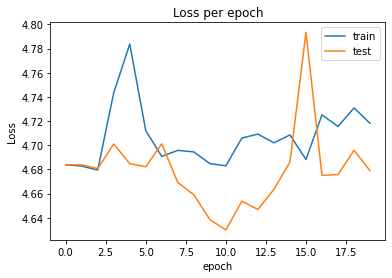

In [190]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## Time Frame = 70ms

In [196]:
X_train = []
X_val = []
X_test = []

time_frame  = 0.070
for train_path in X_train_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=time_frame)
    X_train.append(librosa_audio_data.tolist())

for val_path in X_val_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=time_frame)
    X_val.append(librosa_audio_data.tolist())

for test_path in X_test_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=time_frame)
    X_test.append(librosa_audio_data.tolist())

X_train= np.array(X_train)
X_val= np.array(X_val)
X_test= np.array(X_test)

In [197]:
input_70ms = X_train.shape[1]

In [198]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(128,input_shape=(input_70ms, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [199]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=20)

Epoch 1/20
311/311 [==============================] - 24s 73ms/step - loss: 4.6832 - val_loss: 4.6837
Epoch 2/20
311/311 [==============================] - 22s 72ms/step - loss: 4.6823 - val_loss: 4.6856
Epoch 3/20
311/311 [==============================] - 22s 72ms/step - loss: 4.6814 - val_loss: 4.6864
Epoch 4/20
311/311 [==============================] - 22s 72ms/step - loss: 4.6790 - val_loss: 4.6879
Epoch 5/20
311/311 [==============================] - 22s 72ms/step - loss: 4.6767 - val_loss: 4.6852
Epoch 6/20
311/311 [==============================] - 23s 73ms/step - loss: 4.7433 - val_loss: 4.7025
Epoch 7/20
311/311 [==============================] - 23s 74ms/step - loss: 4.7321 - val_loss: 4.6948
Epoch 8/20
311/311 [==============================] - 23s 74ms/step - loss: 4.7133 - val_loss: 4.6944
Epoch 9/20
311/311 [==============================] - 23s 74ms/step - loss: 4.7203 - val_loss: 4.6939
Epoch 10/20
311/311 [==============================] - 23s 74ms/step - loss: 4.702

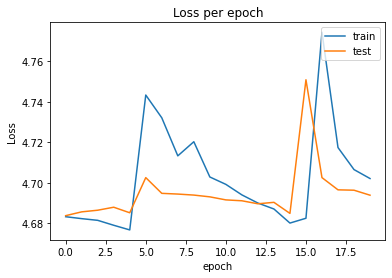

In [200]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## Time Frame = 150ms

In [201]:
X_train = []
X_val = []
X_test = []

time_frame  = 0.150
for train_path in X_train_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=time_frame)
    X_train.append(librosa_audio_data.tolist())

for val_path in X_val_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=time_frame)
    X_val.append(librosa_audio_data.tolist())

for test_path in X_test_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=time_frame)
    X_test.append(librosa_audio_data.tolist())

X_train= np.array(X_train)
X_val= np.array(X_val)
X_test= np.array(X_test)

In [202]:
input_150ms = X_train.shape[1]

In [203]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(128,input_shape=(input_150ms, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [204]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=10)

Epoch 1/10
311/311 [==============================] - 47s 146ms/step - loss: 4.6830 - val_loss: 4.6835
Epoch 2/10
311/311 [==============================] - 45s 145ms/step - loss: 4.6821 - val_loss: 4.6844
Epoch 3/10
311/311 [==============================] - 45s 145ms/step - loss: 4.6805 - val_loss: 4.6837
Epoch 4/10
311/311 [==============================] - 47s 150ms/step - loss: 4.7036 - val_loss: 4.7410
Epoch 5/10
311/311 [==============================] - 46s 147ms/step - loss: 4.7166 - val_loss: 4.7090
Epoch 6/10
311/311 [==============================] - 46s 148ms/step - loss: 4.7164 - val_loss: 4.6973
Epoch 7/10
311/311 [==============================] - 46s 147ms/step - loss: 4.7050 - val_loss: 4.6949
Epoch 8/10
311/311 [==============================] - 46s 148ms/step - loss: 4.7025 - val_loss: 4.6961
Epoch 9/10
311/311 [==============================] - 46s 149ms/step - loss: 4.7055 - val_loss: 4.6956
Epoch 10/10
311/311 [==============================] - 46s 148ms/step - l

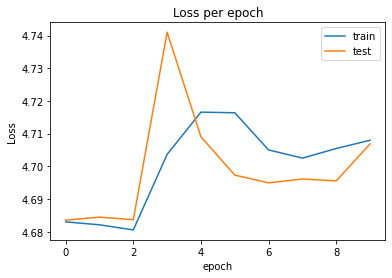

In [205]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## Time Frame = 300ms

In [206]:
X_train = []
X_val = []
X_test = []

time_frame  = 0.300
for train_path in X_train_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=time_frame)
    X_train.append(librosa_audio_data.tolist())

for val_path in X_val_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=time_frame)
    X_val.append(librosa_audio_data.tolist())

for test_path in X_test_path.tolist():
    librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=time_frame)
    X_test.append(librosa_audio_data.tolist())

X_train= np.array(X_train)
X_val= np.array(X_val)
X_test= np.array(X_test)

In [207]:
input_300ms = X_train.shape[1]

In [208]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(128,input_shape=(input_300ms, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 108)               13932     
                                                                 
Total params: 80,492
Trainable params: 80,492
Non-trainable params: 0
_________________________________________________________________


In [209]:
%%time
history = model.fit(x = X_train,y = y_train.values,validation_data=(X_val,y_val.values),epochs=20)

Epoch 1/20
311/311 [==============================] - 89s 281ms/step - loss: 4.6836 - val_loss: 4.6841
Epoch 2/20
311/311 [==============================] - 87s 280ms/step - loss: 4.6822 - val_loss: 4.6867
Epoch 3/20
311/311 [==============================] - 88s 284ms/step - loss: 4.8415 - val_loss: 4.7133
Epoch 4/20
311/311 [==============================] - 89s 285ms/step - loss: 4.7807 - val_loss: 4.7020
Epoch 5/20
311/311 [==============================] - 89s 285ms/step - loss: 4.7534 - val_loss: 4.7000
Epoch 6/20
311/311 [==============================] - 89s 286ms/step - loss: 4.7317 - val_loss: 4.6975
Epoch 7/20
311/311 [==============================] - 89s 286ms/step - loss: 4.7243 - val_loss: 4.6976
Epoch 8/20
311/311 [==============================] - 89s 285ms/step - loss: 4.7170 - val_loss: 4.6951
Epoch 9/20
311/311 [==============================] - 89s 285ms/step - loss: 4.7126 - val_loss: 4.6975
Epoch 10/20
311/311 [==============================] - 89s 285ms/step - l

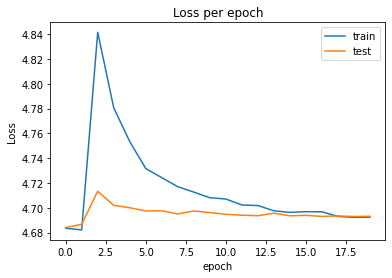

In [210]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Part D: Extract Features
For further reading go to [here](https://devopedia.org/audio-feature-extraction). In this part, we're going to use **MFCC**.
## 1. Zero Crossing Rate
The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

## 2. Spectral Centroid
It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.
# 3.MFCC — Mel-Frequency Cepstral Coefficients
This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

For example:

In [20]:
librosa_audio_data,librosa_sample_rate=librosa.load("converted/0_0.wav")
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 44)


In [33]:
def features_extractor(file,time_frame):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast',duration=time_frame) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features.tolist()

In [69]:
X_train_features = []
X_val_features = []
X_test_features = []

time_frame  = 0.250
for train_path in X_train_path.tolist():
  data = features_extractor(train_path,time_frame)
  X_train_features.append(data)

for val_path in X_val_path.tolist():
  data = features_extractor(val_path,time_frame)
  X_val_features.append(data)

for test_path in X_test_path.tolist():
  data = features_extractor(test_path,time_frame)
  X_test_features.append(data)

In [70]:
X_train_features= np.array(X_train_features)
X_val_features= np.array(X_val_features)
X_test_features= np.array(X_test_features)

In [75]:
X_train_features2 = np.reshape(X_train_features, (X_train_features.shape[0], 1, X_train_features.shape[1]))
X_val_features2 = np.reshape(X_val_features, (X_val_features.shape[0], 1, X_val_features.shape[1]))
X_test_features2 = np.reshape(X_test_features, (X_test_features.shape[0], X_test_features.shape[1],1))

In [62]:
n_mfcc = X_train_features.shape[1] # 40 Features
n_mfcc

40

In [82]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(256,input_shape=(n_mfcc, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 108)               27756     
                                                                 
Total params: 291,948
Trainable params: 291,948
Non-trainable params: 0
_________________________________________________________________


In [83]:
%%time
history = model.fit(x = X_train_features,y = y_train.values,validation_data=(X_val_features,y_val.values),epochs=50)

Epoch 1/50
311/311 [==============================] - 3s 7ms/step - loss: 3.5264 - val_loss: 2.8838
Epoch 2/50
311/311 [==============================] - 2s 6ms/step - loss: 2.7483 - val_loss: 2.5370
Epoch 3/50
311/311 [==============================] - 2s 6ms/step - loss: 2.5373 - val_loss: 2.4195
Epoch 4/50
311/311 [==============================] - 2s 6ms/step - loss: 2.3520 - val_loss: 2.2854
Epoch 5/50
311/311 [==============================] - 2s 6ms/step - loss: 2.2306 - val_loss: 2.2079
Epoch 6/50
311/311 [==============================] - 2s 6ms/step - loss: 2.1308 - val_loss: 2.1375
Epoch 7/50
311/311 [==============================] - 2s 6ms/step - loss: 2.0418 - val_loss: 2.0647
Epoch 8/50
311/311 [==============================] - 2s 6ms/step - loss: 1.9685 - val_loss: 2.0335
Epoch 9/50
311/311 [==============================] - 2s 6ms/step - loss: 1.9038 - val_loss: 2.0100
Epoch 10/50
311/311 [==============================] - 2s 6ms/step - loss: 1.8340 - val_loss: 1.9457

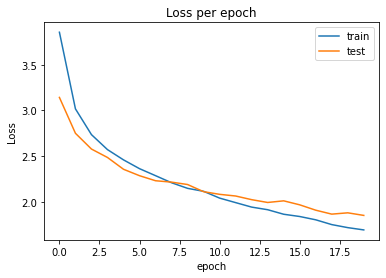

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [84]:
from sklearn.metrics import confusion_matrix, classification_report
prediction = model.predict(X_test_features2)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())

print(classification_report(y_test['note'].values.tolist(), prediction))

              precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.20      0.50      0.29         8
           2       0.12      0.06      0.08        18
           3       0.55      0.29      0.37        21
           4       0.25      0.20      0.22        10
           5       0.19      0.30      0.23        10
           6       0.18      0.18      0.18        11
           7       0.27      0.25      0.26        12
           8       0.15      0.25      0.19         8
           9       0.33      0.45      0.38        11
          10       0.25      0.20      0.22        10
          11       0.60      0.80      0.69        15
          12       0.44      0.29      0.35        14
          13       0.24      0.33      0.28        12
          14       0.64      0.58      0.61        12
          15       0.33      0.50      0.40        10
          16       0.43      0.19      0.26        16
          17       0.24    

<Figure size 720x576 with 0 Axes>

# Part E: Data Augmentation


1.   **Noise Injection:** It simply add some random value into data by using numpy.

2.   **Shifting Time:**The idea of shifting time is very simple. It just shift audio to left/right with a random second.
3.   **Changing Speed:** It stretches times series by a fixed rate.

In this part we're going to use Noise Injection mehtod for data augmentation.





In [85]:
def manipulate(data, noise_factor):
  noise = np.random.randn(len(data))
  augmented_data = data + noise_factor * noise
  # Cast back to same data type
  augmented_data = augmented_data.astype(type(data[0]))
  return augmented_data

In [89]:
def features_extractor_noise(file,time_frame):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast',duration=time_frame)
    audio = manipulate(librosa_audio_data,1)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features.tolist()

In [86]:
librosa_audio_data,librosa_sample_rate=librosa.load('converted/0_0.wav',duration=0.25)

In [88]:
manipulate(librosa_audio_data,1)

array([ 0.85480744,  0.6420496 ,  0.5167906 , ..., -1.0347534 ,
       -0.39788714,  1.2686436 ], dtype=float32)

In [90]:
X_train_features = []
X_val_features = []
X_test_features = []

time_frame  = 0.250
for train_path in X_train_path.tolist():
  data = features_extractor(train_path,time_frame)
  X_train_features.append(data)

for train_path in X_train_path.tolist():
  data = features_extractor_noise(train_path,time_frame)
  X_train_features.append(data)

for val_path in X_val_path.tolist():
  data = features_extractor(val_path,time_frame)
  X_val_features.append(data)

for test_path in X_test_path.tolist():
  data = features_extractor(test_path,time_frame)
  X_test_features.append(data)

In [95]:
X_train_features= np.array(X_train_features)
X_val_features= np.array(X_val_features)
X_test_features= np.array(X_test_features)

In [100]:
X_train_features2 = np.reshape(X_train_features, (X_train_features.shape[0], X_train_features.shape[1] ,1))
X_val_features2 = np.reshape(X_val_features, (X_val_features.shape[0], 1, X_val_features.shape[1]))
X_test_features2 = np.reshape(X_test_features, (X_test_features.shape[0], X_test_features.shape[1],1))

In [101]:
y_train2 = pd.concat([y_train,y_train],axis=0)

In [102]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(256,input_shape=(n_mfcc, 1)))
# Dropout Layer
model.add(Dropout(0.5))
# Final Prediction
model.add(Dense(notes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 108)               27756     
                                                                 
Total params: 291,948
Trainable params: 291,948
Non-trainable params: 0
_________________________________________________________________


In [103]:
%%time
history = model.fit(x = X_train_features2,y = y_train2.values,validation_data=(X_val_features,y_val.values),epochs=50)

Epoch 1/50
622/622 [==============================] - 5s 6ms/step - loss: 4.0332 - val_loss: 2.6792
Epoch 2/50
622/622 [==============================] - 3s 5ms/step - loss: 3.6511 - val_loss: 2.4329
Epoch 3/50
622/622 [==============================] - 3s 5ms/step - loss: 3.5369 - val_loss: 2.3183
Epoch 4/50
622/622 [==============================] - 3s 5ms/step - loss: 3.4656 - val_loss: 2.2103
Epoch 5/50
622/622 [==============================] - 3s 5ms/step - loss: 3.4045 - val_loss: 2.1797
Epoch 6/50
622/622 [==============================] - 3s 5ms/step - loss: 3.3564 - val_loss: 2.1165
Epoch 7/50
622/622 [==============================] - 3s 5ms/step - loss: 3.3210 - val_loss: 2.0510
Epoch 8/50
622/622 [==============================] - 3s 5ms/step - loss: 3.2889 - val_loss: 2.0034
Epoch 9/50
622/622 [==============================] - 3s 5ms/step - loss: 3.2531 - val_loss: 2.0000
Epoch 10/50
622/622 [==============================] - 3s 5ms/step - loss: 3.2149 - val_loss: 1.8698

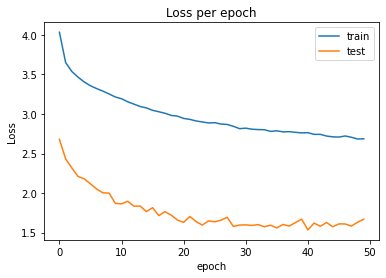

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [105]:
from sklearn.metrics import confusion_matrix, classification_report
prediction = model.predict(X_test_features2)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())

print(classification_report(y_test['note'].values.tolist(), prediction))

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.33      0.25      0.29         8
           2       0.22      0.33      0.27        18
           3       0.20      0.05      0.08        21
           4       0.17      0.30      0.21        10
           5       0.29      0.20      0.24        10
           6       0.14      0.18      0.16        11
           7       0.33      0.33      0.33        12
           8       0.25      0.12      0.17         8
           9       0.36      0.45      0.40        11
          10       0.75      0.30      0.43        10
          11       0.69      0.73      0.71        15
          12       0.89      0.57      0.70        14
          13       0.47      0.67      0.55        12
          14       0.50      0.42      0.45        12
          15       0.55      0.60      0.57        10
          16       0.45      0.62      0.53        16
          17       0.50    

<Figure size 720x576 with 0 Axes>

# Part F: Using CNN and RNN

In [106]:
librosa_audio_data,librosa_sample_rate=librosa.load('converted/0_0.wav',duration=0.25)

In [110]:
S = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram of 0_0.wav')]

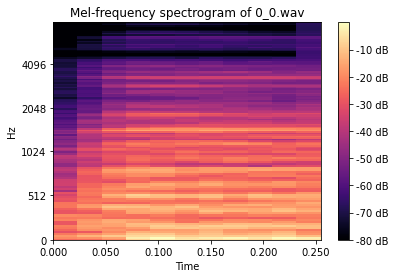

In [115]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=librosa_sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram of 0_0.wav')

In [120]:
X_train_spectrogram = []
X_val_spectrogram = []
X_test_spectrogram = []

time_frame  = 0.250
for train_path in X_train_path.tolist():
  librosa_audio_data,librosa_sample_rate=librosa.load(train_path,duration=0.25)
  data = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128,
                                    fmax=8000)
  X_train_spectrogram.append(data.tolist())

for val_path in X_val_path.tolist():
  librosa_audio_data,librosa_sample_rate=librosa.load(val_path,duration=0.25)
  data = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128,
                                    fmax=8000)
  X_val_spectrogram.append(data.tolist())

for test_path in X_test_path.tolist():
  librosa_audio_data,librosa_sample_rate=librosa.load(test_path,duration=0.25)
  data = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128,
                                    fmax=8000)
  X_test_spectrogram.append(data.tolist())

In [123]:
X_train_spectrogram= np.array(X_train_spectrogram)
X_val_spectrogram= np.array(X_val_spectrogram)
X_test_spectrogram= np.array(X_test_spectrogram)

In [142]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 11
N_CHANNELS = 1

In [154]:
X_train_spectrogram2 = np.reshape(X_train_spectrogram, (X_train_spectrogram.shape[0], X_train_spectrogram.shape[1] ,X_train_spectrogram.shape[2],N_CHANNELS))
X_val_spectrogram2 = np.reshape(X_val_spectrogram, (X_val_spectrogram.shape[0], X_val_spectrogram.shape[1], X_val_spectrogram.shape[2],N_CHANNELS))
X_test_spectrogram2 = np.reshape(X_test_spectrogram, (X_test_spectrogram.shape[0], X_test_spectrogram.shape[1],X_val_spectrogram.shape[2],N_CHANNELS))

In [155]:
X_train_spectrogram2.shape

(9952, 128, 11, 1)

In [156]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [167]:
# Create CNN/RNN model
model = Sequential()
model.add(TimeDistributedConvolution2D(64, 3, 3, border_mode='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, N_CHANNELS)))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(256, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(TimeDistributedConvolution2D(256, 3, 3))
model.add(Activation('relu'))
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(TimeDistributedFlatten())
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
#Output
model.add(TimeDistributedDense(notes))
model.add(Activation('softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam'
)

In [168]:
%%time
history = model.fit(x = X_train_spectrogram2,y = y_train.values,validation_data=(X_val_spectrogram2,y_val.values),epochs=50)

Epoch 1/50
311/311 [==============================] - 2s 5ms/step - loss: 3.3418 - val_loss: 3.2967
Epoch 2/50
311/311 [==============================] - 1s 5ms/step - loss: 2.1720 - val_loss: 2.3666
Epoch 3/50
311/311 [==============================] - 1s 5ms/step - loss: 1.8489 - val_loss: 2.0080
Epoch 4/50
311/311 [==============================] - 1s 5ms/step - loss: 1.6750 - val_loss: 2.6576
Epoch 5/50
311/311 [==============================] - 1s 5ms/step - loss: 1.5300 - val_loss: 2.5053
Epoch 6/50
311/311 [==============================] - 1s 5ms/step - loss: 1.4242 - val_loss: 2.1276
Epoch 7/50
311/311 [==============================] - 2s 5ms/step - loss: 1.3528 - val_loss: 2.1610
Epoch 8/50
311/311 [==============================] - 2s 5ms/step - loss: 1.2649 - val_loss: 2.4121
Epoch 9/50
311/311 [==============================] - 1s 5ms/step - loss: 1.2070 - val_loss: 2.7080
Epoch 10/50
311/311 [==============================] - 2s 5ms/step - loss: 1.1540 - val_loss: 1.6822

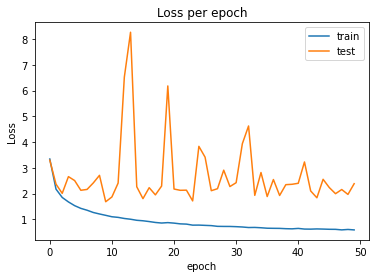

In [169]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [171]:
from sklearn.metrics import confusion_matrix, classification_report
prediction = model.predict(X_test_spectrogram2)
prediction = np.argmax(prediction,axis=1).tolist()

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(prediction, y_test['note'].values.tolist())

print(classification_report(y_test['note'].values.tolist(), prediction))

              precision    recall  f1-score   support

           0       0.25      0.08      0.12        12
           1       0.00      0.00      0.00         8
           2       0.10      0.17      0.12        18
           3       0.29      0.10      0.14        21
           4       0.00      0.00      0.00        10
           5       0.09      0.30      0.14        10
           6       1.00      0.09      0.17        11
           7       0.67      0.17      0.27        12
           8       0.07      0.12      0.09         8
           9       0.00      0.00      0.00        11
          10       0.33      0.20      0.25        10
          11       0.33      0.07      0.11        15
          12       0.00      0.00      0.00        14
          13       0.80      0.33      0.47        12
          14       0.00      0.00      0.00        12
          15       0.22      0.20      0.21        10
          16       0.29      0.25      0.27        16
          17       0.73    

<Figure size 720x576 with 0 Axes>